In [1]:
from netCDF4 import Dataset
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
s3_path='S3A_OL_2_WFR____20180825T201633_20180825T201933_20180827T024047_0179_035_071_1800_MAR_O_NT_002.SEN3'
rrs_412_path=s3_path+'/Oa02_reflectance.nc'
rrs_443_path=s3_path+'/Oa03_reflectance.nc'
rrs_490_path=s3_path+'/Oa04_reflectance.nc'
rrs_510_path=s3_path+'/Oa05_reflectance.nc'
rrs_560_path=s3_path+'/Oa06_reflectance.nc'
rrs_620_path=s3_path+'/Oa07_reflectance.nc'
rrs_665_path=s3_path+'/Oa08_reflectance.nc'
rrs_865_path=s3_path+'/Oa17_reflectance.nc'

rrs_412=Dataset(rrs_412_path)
rrs_443=Dataset(rrs_443_path)
rrs_490=Dataset(rrs_490_path)
rrs_510=Dataset(rrs_510_path)
rrs_560=Dataset(rrs_560_path)
rrs_620=Dataset(rrs_620_path)
rrs_665=Dataset(rrs_665_path)
rrs_865=Dataset(rrs_865_path)
height,width=np.shape(np.array(rrs_412['Oa02_reflectance']))[0],np.shape(np.array(rrs_412['Oa02_reflectance']))[1]
cell_nums=height*width 
rrs_412,rrs_443,rrs_490,rrs_510,rrs_560,rrs_620,rrs_665=np.array(rrs_412['Oa02_reflectance']).reshape(cell_nums),np.array(rrs_443['Oa03_reflectance']).reshape(cell_nums),np.array(rrs_490['Oa04_reflectance']).reshape(cell_nums),np.array(rrs_510['Oa05_reflectance']).reshape(cell_nums),np.array(rrs_560['Oa06_reflectance']).reshape(cell_nums),np.array(rrs_620['Oa07_reflectance']).reshape(cell_nums),np.array(rrs_665['Oa08_reflectance']).reshape(cell_nums)
bgi,i=rrs_443/rrs_560,rrs_490/rrs_560
rrs_865=np.array(rrs_865['Oa17_reflectance'])
rrs_412[rrs_412>1000]=None
rrs_443[rrs_443>1000]=None
rrs_490[rrs_490>1000]=None
rrs_510[rrs_510>1000]=None
rrs_560[rrs_560>1000]=None
rrs_620[rrs_620>1000]=None
rrs_665[rrs_665>1000]=None
rrs_865[rrs_865>1000]=None

features=np.stack((rrs_412,rrs_443,rrs_490,rrs_510,rrs_560,rrs_620,rrs_665,bgi,i),axis=0)
features= features.transpose(1,0)
robust=RobustScaler()
mm = MinMaxScaler()
features=robust.fit_transform(features)
features=mm.fit_transform(features)

Iteration 0
Avgtrainml 0.005861573852598667
avgtestml 0.01391463354229927
Iteration 500
Avgtrainml 0.05217276195537449
avgtestml 0.11376505520045695
Iteration 1000
Avgtrainml 0.03592042207355451
avgtestml 0.09856201787481769
R2=0.817
rmse=0.389


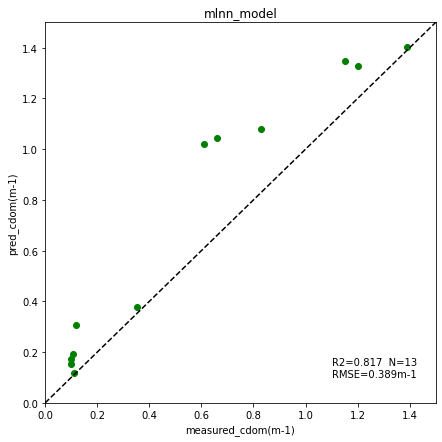

In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import math

import random
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)
#加载数据,
data=pd.read_excel('L2_2.xlsx')
data=np.array(data)\
#建立样本\n",
feature=data[:,:-2]
target=data[:,-2]
category=data[:,-1]
robust=RobustScaler()
mm = MinMaxScaler()
feature=robust.fit_transform(feature)
feature=mm.fit_transform(feature)
train_x,test_x,train_y,test_y=train_test_split(feature,target,stratify=category,test_size=0.2,random_state=1)
train_x,val_x,train_y,val_y=train_test_split(train_x,train_y,test_size=0.25,random_state=2)

n_input,n_train_samples,n_val_samples,n_test_samples=9,38,13,13
x_train_tensor=torch.from_numpy(np.float32(train_x).reshape(n_train_samples,n_input))
y_teain_tensor=torch.from_numpy(np.float32(train_y).reshape(n_train_samples,1))
x_train_variable,y_train_variable=Variable(x_train_tensor),Variable(y_teain_tensor,requires_grad=False)
x_val_tensor=torch.from_numpy(np.float32(val_x).reshape(n_val_samples,n_input))
y_val_tensor=torch.from_numpy(np.float32(val_y).reshape(n_val_samples,1))
x_val_variable,y_val_variable=Variable(x_val_tensor),Variable(y_val_tensor,requires_grad=False)

#构建模型
class SineModel(nn.Module):
    def __init__(self):
        super(SineModel, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(9,20),
            nn.ReLU(),
            nn.Linear(20,1),
            #nn.ReLU(),
            #nn.Linear(20,1)
        )
    def forward(self,x):
        return self.main(x)
#n内循环
def do_base_learning(model,x,y,lr_inner,n_inner):
    new_model=SineModel()
    new_model.load_state_dict(model.state_dict())
    inner_optimizer=torch.optim.SGD(new_model.parameters(),lr=lr_inner)
    for i in range(n_inner):
        y_true=y
        y_pred=new_model(x)
        loss=((y_pred-y_true)**2).mean()
        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()
    return new_model
def do_base_eval(new_model,x,y):
    y_true=y
    y_pred=new_model(x)
    loss=((y_pred-y_true)**2).mean()
    return loss.item()
def reptile_sine(model,iterrations,lr_inner=0.01,lr_outer=0.003,n_inner=3):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr_outer)
    train_metalosses=[]
    test_metalosses=[]
    inner_optimizer=None
    # Sample an epoch by shuffling all training tasks
    for t in range(iterrations):
        i=random.randint(0,n_train_samples-1)
        x_train=x_train_variable[i]
        y_train=y_train_variable[i]
        # Take k gradient steps
        new_model=do_base_learning(model,x_train,y_train,lr_inner,n_inner)
        # Eval
        train_metaloss=do_base_eval(new_model,x_train,y_train)
        # Inject updates into each .grad
        for p,new_p in zip(model.parameters(),new_model.parameters()):
            if p.grad is None:
                p.grad=Variable(torch.zeros(p.size()))
            p.grad.data.add_(p.data-new_p.data)
        # Update meta-parameters
        optimizer.step()
        optimizer.zero_grad()
        # Validation
        j=random.randint(0,n_val_samples-1)
        x_val=x_val_variable[j]
        y_val=y_val_variable[j]
        new_model=do_base_learning(model,x_val,y_val,lr_inner,n_inner)
        test_metaloss=do_base_eval(new_model,x_val,y_val)
        train_metalosses.append(train_metaloss)
        test_metalosses.append(test_metaloss)
        if t %500==0:
            print('Iteration',t)
            print('Avgtrainml',np.mean(train_metalosses))
            print('avgtestml',np.mean(test_metalosses))
model=SineModel()
reptile_sine(model,iterrations=1500)

import math
from sklearn.metrics import mean_squared_error   #均方误差
from sklearn.metrics import mean_absolute_error  #平均绝对误
from sklearn.metrics import r2_score

x_test_tensor=torch.from_numpy(np.float32(test_x).reshape(n_test_samples,n_input))
x_test_variable=Variable(x_test_tensor)

y_pred=model(x_test_variable).detach().numpy()
test_y=np.array(test_y)
rmse=math.sqrt(mean_absolute_error(test_y,y_pred))
r2=r2_score(test_y,y_pred)
print('R2='+str(r2)[:5])
print('rmse='+str(rmse)[:5])
#作图
fig, ax = plt.subplots(1, 1,figsize=(7,7))
plt.scatter(test_y,y_pred,color='green')
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k')       #绘制1:1对角线
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.ylabel('pred_cdom(m-1)')
plt.xlabel('measured_cdom(m-1)')
plt.title('mlnn_model')
plt.text(1.1,0.15,'R2='+str(r2)[:5]+'  N=13',size=10)
plt.text(1.1,0.1,'RMSE='+str(rmse)[:5]+'m-1',size=10)
plt.show()

In [13]:
x_test_tensor = torch.from_numpy(features)
x_test_variable=Variable(x_test_tensor)
sampled=model(x_test_variable).detach().numpy()
result=sampled.reshape(height,width)
result=np.abs(result)

In [14]:
corr_path=s3_path+'/geo_coordinates.nc'
latitude=Dataset(corr_path)
longitude=Dataset(corr_path)
latitude=np.array(latitude['latitude'])
longitude=np.array(longitude['longitude'])
cdom=np.array(result)

new_nc=Dataset('new_nc_8.nc','w',format='NETCDF4')
new_nc.createDimension('latsize',height)
new_nc.createDimension('lonsize',width)
new_nc.createVariable('lat',np.float64,('latsize','lonsize'))
new_nc.createVariable('lon',np.float64,('latsize','lonsize'))
new_nc.createVariable('cdom',np.float32,('latsize','lonsize'))
new_nc.variables['lat'][:]=latitude
new_nc.variables['lon'][:]=longitude
new_nc.variables['cdom'][:]=cdom
new_nc.close()